# Tutorial 2: MERFISH dataset

Here, we further tested FlatST on the imaging-based dataset MERFISH after the sequencing dataset.

## Import the necessary modules

In [2]:
import scanpy as sc
from sklearn import metrics
import pandas as pd
from sklearn import mixture
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score
import FlatST
import tracemalloc
import time

## Run FlatST

------Calculating spatial graph...
The graph contains 329562 edges, 5803 cells.
56.7917 neighbors per cell on average.


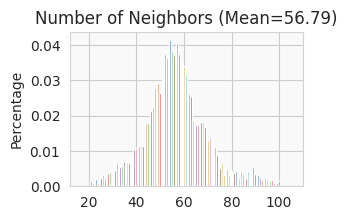

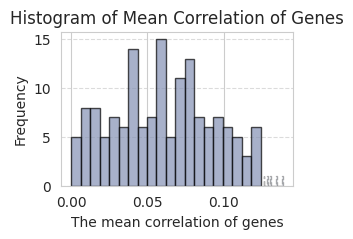

Size of Input:  (5803, 150)


100%|██████████| 1000/1000 [00:36<00:00, 27.07it/s]
R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%
Now is 1 times
memory blocks peak:  349.2905 MB
time: 46.3235 s
ARI:0.6552039998805713


In [ ]:
slice = [0.04,0.09,0.14,0.19,0.24]
for j in range(3,4):
    datadir = rf'/mnt/mydisk/home/chenxd/lwfx/data/3_MERFISH/MERFISH_{slice[j]}.h5ad'
    result_path = r'/mnt/mydisk/home/chenxd/lwfx/res/MERFISH'
    run_num = 1
    # save res
    new_adata = sc.read_h5ad(f'{datadir}')
    target_num = new_adata.obs['Region'].nunique()
    method = 'FlatST'
    dataset = f'MERFISH_{slice[j]}'

    memory = [0] * run_num
    during_time = [0] * run_num
    ari_list = [0] * run_num
    nmi_list = [0] * run_num
    
    for i in range(run_num):
        tracemalloc.start()
        start_time = time.time()

        adata = sc.read_h5ad(datadir)
        adata.var_names_make_unique()
        # Normalization
        sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=3000)
        sc.pp.normalize_total(adata, target_sum=1e4)
        sc.pp.log1p(adata)

        # Constructing the spatial network
        FlatST.Cal_Spatial_Net(adata, rad_cutoff=100)
        FlatST.Stats_Spatial_Net(adata)
        # Running STAGATE
        adata = FlatST.train_FlatST(adata,n_epochs=1000,hidden_dims=[610,10],cuda_device=2,
                            num_smooth_iterations=[1,0],keep_percent=0.97,initial_alpha=1.0,is_distribution=1.0,is_early_stopping=0) 
        adata = FlatST.mclust_R(adata, used_obsm='FlatST', num_cluster=target_num)
        new_adata.obs['pred_{}'.format(i+1)]=adata.obs['mclust']
        
        obs_df = adata.obs.dropna()
        ari = adjusted_rand_score(obs_df['mclust'], obs_df['Region'])
        ari_list[i] = ari
        nmi = normalized_mutual_info_score(obs_df['mclust'], obs_df['Region'])
        nmi_list[i] = nmi
        end_time = time.time()
        during = end_time - start_time

        size, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        
        memory[i] = peak / 1024 / 1024
        during_time[i] = during

        print('Now is {} times'.format(i+1))
        print('memory blocks peak:{:>10.4f} MB'.format(memory[i]))
        print('time: {:.4f} s'.format(during_time[i]))
        print('ARI:{}'.format(ari_list[i]), 'NMI:{}'.format(nmi_list[i]))

    new_adata.uns['time']=during_time
    new_adata.uns['memory']=memory
    new_adata.uns['ari']=ari_list
    new_adata.uns['nmi']=nmi_list
    # new_adata.write(f'{result_path}/{method}_{dataset}_100_.h5ad')

## Find the best-performing model

In [4]:
# adata  = sc.read_h5ad(f'{result_path}/{method}_{slice_num}.h5ad')
adata = new_adata
ari_array = np.array(adata.uns['ari'])
a,a_loc = np.max(ari_array),np.argmax(ari_array)
b,b_loc = np.min(ari_array),np.argmin(ari_array)
print('max ARI is {:.2f}, loc is {}'.format(a,a_loc+1))

max ARI is 0.66, loc is 1


## Draw the result

[<Axes: title={'center': 'Region'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'ARI=0.655'}, xlabel='spatial1', ylabel='spatial2'>]

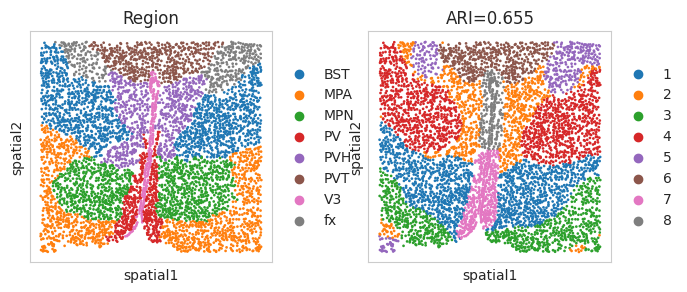

In [14]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(new_adata, basis="spatial", color=['Region',"pred_" + str(a_loc+1)], s=15, show=False,title=['Region',f'ARI={a:.3f}'])

## Match colors

In [9]:
adata = adata[~adata.obs['Region'].isna()]
pred = 'pred_{}'.format(a_loc+1)
dic = FlatST.find_region_mapping(adata,pred)
dic

{4: 'BST', 1: 'MPN', 3: 'MPA', 2: 'PVH', 6: 'PVT', 7: 'PV', 5: 'fx', 8: 'V3'}

In [10]:
# Map the numerical label of mclust to the Layer name
adata.obs['mclust'] = adata.obs[pred].map(dic)
# Force the category order of mclust to be exactly the same as that of Region
region_order = adata.obs['Region'].astype('category').cat.categories.tolist()
adata.obs['mclust'] = pd.Categorical(
    adata.obs['mclust'], 
    categories=region_order  # Key: Align the order with Region
)

[<Axes: title={'center': 'Region'}, xlabel='spatial1', ylabel='spatial2'>,
 <Axes: title={'center': 'ARI=0.655'}, xlabel='spatial1', ylabel='spatial2'>]

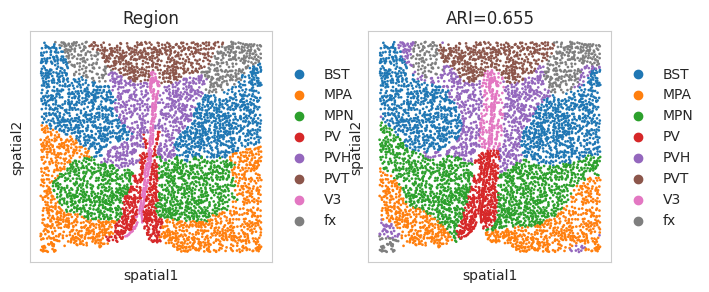

In [15]:
plt.rcParams["figure.figsize"] = (3, 3)
sc.pl.embedding(adata, basis="spatial", color=['Region','mclust'], s=15, show=False,title=['Region',f'ARI={a:.3f}'])